import des bibliotheques

In [31]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set()


collecte / chargement du corpus

In [32]:
from datasets import load_dataset

# Parquet files are under: <lang>/train/0000.parquet in the parquet-converted branch
en = load_dataset(
    "parquet",
    data_files="hf://datasets/mteb/amazon_reviews_multi@refs/convert/parquet/en/train/*.parquet",
    split="train"
)

fr = load_dataset(
    "parquet",
    data_files="hf://datasets/mteb/amazon_reviews_multi@refs/convert/parquet/fr/train/*.parquet",
    split="train"
)

# Sample 500 each (reproducible)
#n_500 = en.shuffle(seed=42).select(range(500))
#r_500 = fr.shuffle(seed=42).select(range(500))

#print(len(en_500), len(fr_500))
#print(en_500.column_names)
#print(fr_500[0])

In [33]:
from collections import Counter

def stratified_sample(ds, label_col="label", n=500, seed=42):
    rng = np.random.default_rng(seed)
    labels = np.array(ds[label_col])
    unique, counts = np.unique(labels, return_counts=True)
    total = counts.sum()

    # nombre d’exemples à prendre par classe (proportionnel)
    n_per_class = {int(u): int(round(n * (c / total))) for u, c in zip(unique, counts)}

    # Ajustement pour tomber exactement à n (à cause des arrondis)
    diff = n - sum(n_per_class.values())
    if diff != 0:
        # on ajoute/enlève 1 aux classes les plus fréquentes
        order = sorted(unique, key=lambda u: counts[list(unique).index(u)], reverse=True)
        i = 0
        step = 1 if diff > 0 else -1
        while diff != 0:
            k = int(order[i % len(order)])
            n_per_class[k] = max(0, n_per_class[k] + step)
            diff -= step
            i += 1

    # Tirage d’indices par classe
    idx = []
    for lab in unique:
        lab = int(lab)
        lab_idx = np.where(labels == lab)[0]
        take = min(n_per_class[lab], len(lab_idx))
        chosen = rng.choice(lab_idx, size=take, replace=False)
        idx.extend(chosen.tolist())

    # Mélange final + sélection
    idx = rng.permutation(idx).tolist()
    return ds.select(idx)

# Usage
en_500 = stratified_sample(en, label_col="label", n=500, seed=42)
fr_500 = stratified_sample(fr, label_col="label", n=500, seed=42)

print("EN label:", Counter(en_500["label"]))
print("FR label:", Counter(fr_500["label"]))

EN label: Counter({0: 100, 2: 100, 1: 100, 4: 100, 3: 100})
FR label: Counter({0: 100, 2: 100, 1: 100, 4: 100, 3: 100})


In [34]:
import pandas as pd

df_en = en_500.to_pandas()
df_fr = fr_500.to_pandas()

df_en.head()
#df_fr.head()

,id,text,label,label_text
0,en_0079549,"Not What I Thought\n\nSadly, I thought this ob...",0,0
1,en_0470874,But extras\n\nThey work ok. They don’t last fo...,2,2
2,en_0607683,Also they claim it is leather but it feels lik...,2,2
3,en_0922882,"Two Stars\n\nIt's OK, but I was expecting much...",1,1
4,en_0811424,Nice piano-but mic broken in less than an hour...,1,1


In [35]:
from datasets import Dataset

# Ajouter une colonne langue
en_500 = en_500.add_column("lang", ["en"] * len(en_500))
fr_500 = fr_500.add_column("lang", ["fr"] * len(fr_500))


In [36]:
#harmoniser les colonnes
common_cols = list(set(en_500.column_names) & set(fr_500.column_names))

en_500 = en_500.remove_columns([c for c in en_500.column_names if c not in common_cols])
fr_500 = fr_500.remove_columns([c for c in fr_500.column_names if c not in common_cols])


In [37]:
#fusion des datasets
from datasets import concatenate_datasets
dataset_all = concatenate_datasets([en_500, fr_500])

print(dataset_all)



Dataset({
    features: ['id', 'text', 'label', 'label_text', 'lang'],
    num_rows: 1000
})


In [57]:
import pandas as pd

df = dataset_all.to_pandas()
df.head(50)

,id,text,label,label_text,lang
0,en_0079549,"Not What I Thought\n\nSadly, I thought this ob...",0,0,en
1,en_0470874,But extras\n\nThey work ok. They don’t last fo...,2,2,en
2,en_0607683,Also they claim it is leather but it feels lik...,2,2,en
3,en_0922882,"Two Stars\n\nIt's OK, but I was expecting much...",1,1,en
4,en_0811424,Nice piano-but mic broken in less than an hour...,1,1,en
5,en_0492800,"Reasonable price\n\nOddly enough, found finger...",2,2,en
6,en_0316676,Exactly What I Needed\n\nI needed a reliable/n...,4,4,en
7,en_0537829,Not worth the price.\n\nI like the pages and t...,1,1,en
8,en_0622186,Fast and efficient\n\nDefinitely great for the...,3,3,en
9,en_0027463,Don’t buy a waste of money\n\nThis is the wors...,0,0,en


exploration rapide

,label,lang,word_count
count,1000.000000,1000,1000.000000
unique,NaN,2,NaN
top,NaN,en,NaN
freq,NaN,500,NaN
mean,2.000000,NaN,34.316000
std,1.414921,NaN,28.395465
min,0.000000,NaN,3.000000
25%,1.000000,NaN,16.000000
50%,2.000000,NaN,26.000000
75%,3.000000,NaN,42.000000


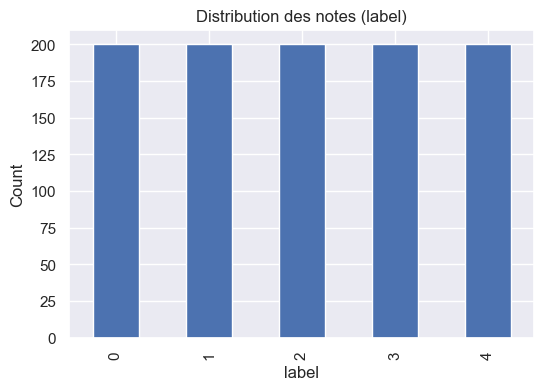

In [39]:
df["text_length"] = df["text"].astype(str).apply(len)
df["word_count"] = df["text"].astype(str).apply(lambda x: len(x.split()))

display(df[["label","lang","word_count"]].describe(include="all")) 

plt.figure(figsize=(6,4))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des notes (label)")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()


creattion d'une etiquette de sentiment

Pour l’évaluation, on transforme la note en 3 classes :
- `negative` : rating ≤ 2
- `neutral`  : rating = 3
- `positive` : rating ≥ 4

In [40]:
def rating_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment"] = df["label"].apply(rating_to_sentiment)
df[["label","sentiment","text"]].head()

,label,sentiment,text
0,0,negative,"Not What I Thought\n\nSadly, I thought this ob..."
1,2,negative,But extras\n\nThey work ok. They don’t last fo...
2,2,negative,Also they claim it is leather but it feels lik...
3,1,negative,"Two Stars\n\nIt's OK, but I was expecting much..."
4,1,negative,Nice piano-but mic broken in less than an hour...


## 3) Préparation des données (Nettoyage + Tokenisation + Stopwords + Lemmatisation + POS)

Le preprocessing est une étape cruciale en NLP. Les étapes typiques incluent :

1. **Nettoyage** : suppression HTML, URLs, caractères spéciaux
2. **Normalisation** : lowercase, accents
3. **Tokenisation** : découpage en mots
4. **Stopwords** : suppression des mots vides (le, la, un, de...)
5. **Lemmatisation/Stemming** : réduction à la forme canonique
6. **POS Tagging** : identification des parties du discours

⚠️ **Attention** : Pour l'analyse de sentiments, certaines étapes doivent être adaptées :
- Ne pas supprimer la ponctuation (!!!, ???) qui porte du sens
- Attention aux négations ("ne", "pas") qui sont des stopwords mais essentielles
- Le lowercase peut faire perdre l'emphase (SUPER vs super)
> Version robuste : stopwords FR + EN, et on **conserve les négations** (important en sentiment).

In [41]:
# Stopwords FR + EN (NLTK)
stop_fr = set(stopwords.words("french"))
stop_en = set(stopwords.words("english"))
stop_all = stop_fr | stop_en
stop_all

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ai',
 'aie',
 'aient',
 'aies',
 'ain',
 'ait',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'ce',
 'ces',
 'couldn',
 "couldn't",
 'd',
 'dans',
 'de',
 'des',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'du',
 'during',
 'each',
 'elle',
 'en',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'few',
 'for',
 'from',
 'furent',
 'furth

In [42]:
# On garde les négations (très utiles en sentiment)
NEGATIONS = {"ne", "pas", "jamais", "rien", "plus", "aucun", "sans", "not", "no", "never", "n't"}
stop_for_cloud_and_models = stop_all - NEGATIONS

In [43]:
# Nettoyage minimal : on garde ! ? (peuvent porter du sentiment)
PUNCT_TO_REMOVE = set(string.punctuation) - set(["!", "?"])

In [44]:
def basic_clean(text: str) -> str:
    text = str(text)
    text = re.sub(r"http\S+|www\S+", " ", text)  # URLs
    text = re.sub(r"<.*?>", " ", text)            # HTML
    text = re.sub(r"\s+", " ", text).strip()     # espaces multiples
    return text
df["text_clean"] = df["text"].apply(basic_clean)

In [45]:
def tokenize(text: str):
    return word_tokenize(text)
df["tokens"] = df["text_clean"].apply(tokenize)

In [46]:
def normalize_tokens(tokens):
    out = []
    for t in tokens:
        t = t.lower()

        # retire ponctuation (sauf ! ?)
        if t in PUNCT_TO_REMOVE:
            continue

        # retire tokens trop courts (évite n, t, etc.)
        if len(t) <= 2 and t not in NEGATIONS:
            continue

        # retire stopwords (sauf négations)
        if t in stop_for_cloud_and_models:
            continue

        # conserve les tokens contenant au moins une lettre
        if not re.search(r"[a-zA-ZÀ-ÿ]", t):
            continue

        out.append(t)
    return out

df["tokens"] = df["tokens"].apply(normalize_tokens)

In [47]:
df[["text","text_clean","tokens"]].head()

,text,text_clean,tokens
0,"Not What I Thought\n\nSadly, I thought this ob...","Not What I Thought Sadly, I thought this objec...","[not, thought, sadly, thought, object, would, ..."
1,But extras\n\nThey work ok. They don’t last fo...,But extras They work ok. They don’t last for m...,"[extras, work, last, weeks, definitely, not, l..."
2,Also they claim it is leather but it feels lik...,Also they claim it is leather but it feels lik...,"[also, claim, leather, feels, like, plastic, g..."
3,"Two Stars\n\nIt's OK, but I was expecting much...","Two Stars It's OK, but I was expecting much mo...","[two, stars, expecting, much]"
4,Nice piano-but mic broken in less than an hour...,Nice piano-but mic broken in less than an hour...,"[nice, piano-but, mic, broken, less, hour, nep..."


wordcloud

In [48]:
all_words = [w for toks in df["tokens"] for w in toks]
freq = Counter(all_words)
print("Top 20 mots:", freq.most_common(20))

Top 20 mots: [('pas', 348), ('not', 227), ('très', 224), ('ne', 181), ('produit', 130), ('bien', 128), ('one', 112), ("n't", 109), ('great', 105), ('good', 104), ('qualité', 102), ('product', 93), ('plus', 86), ('bon', 86), ('like', 81), ('would', 70), ('car', 68), ("j'ai", 65), ('trop', 63), ('tout', 58)]


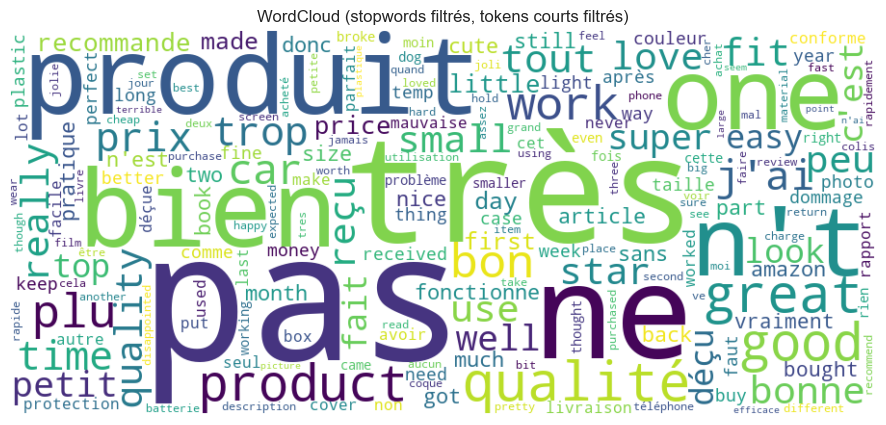

In [49]:
plt.figure(figsize=(12,5))
wc = WordCloud(width=900, height=400, background_color="white", collocations=False)
wc.generate(" ".join(all_words))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (stopwords filtrés, tokens courts filtrés)")
plt.show()

Lemmatisation + POS tagging

In [50]:
import spacy
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")

In [51]:
def spacy_process(text, lang):
    nlp = nlp_en if lang == "en" else nlp_fr
    if nlp is None:
        return [], []
    doc = nlp(text)
    lemmas = []
    pos_tags = []
    for tok in doc:
        if tok.is_space:
            continue
        lem = tok.lemma_.lower()
        if lem in stop_for_cloud_and_models and lem not in NEGATIONS:
            continue
        if len(lem) <= 2 and lem not in NEGATIONS:
            continue
        if lem in PUNCT_TO_REMOVE:
            continue
        if not re.search(r"[a-zA-ZÀ-ÿ]", lem):
            continue
        lemmas.append(lem)
        pos_tags.append(tok.pos_)
    return lemmas, pos_tags

tmp = []
for _, row in df.iterrows():
    lem, pos = spacy_process(row["text_clean"], row["lang"])
    tmp.append((lem, pos))

df["lemmas"] = [t[0] for t in tmp]
df["pos"] = [t[1] for t in tmp]

df[["lang","text_clean","lemmas","pos"]].head()

,lang,text_clean,lemmas,pos
0,en,"Not What I Thought Sadly, I thought this objec...","[not, think, sadly, think, object, would, conn...","[PART, VERB, ADV, VERB, NOUN, AUX, VERB, NOUN,..."
1,en,But extras They work ok. They don’t last for m...,"[extras, work, not, last, week, definitely, no...","[X, VERB, PART, VERB, NOUN, ADV, PART, ADJ, NOUN]"
2,en,Also they claim it is leather but it feels lik...,"[also, claim, leather, feel, like, plastic, gi...","[ADV, VERB, NOUN, VERB, ADP, NOUN, VERB, NOUN,..."
3,en,"Two Stars It's OK, but I was expecting much mo...","[two, star, expect, much]","[NUM, NOUN, VERB, ADV]"
4,en,Nice piano-but mic broken in less than an hour...,"[nice, piano, mic, break, less, hour, nephew, ...","[ADJ, NOUN, ADJ, VERB, ADJ, NOUN, NOUN, VERB, ..."


## 4) Analyse lexicon-based (polarité) + score de sentiment
### 4.1 Utilisation de VADER

In [52]:
vader = SentimentIntensityAnalyzer()

In [53]:
vader.polarity_scores("Also they claim it is leather but it feels like plastic!")

{'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'compound': 0.5487}

In [54]:
# Mini lexique FR pédagogique (à étendre)
LEX_FR = {
    "excellent": 2.0, "super": 1.5, "génial": 1.8, "parfait": 1.8, "rapide": 1.0, "recommande": 1.2,
    "déçu": -1.5, "mauvais": -2.0, "mauvaise": -2.0, "nulle": -2.0, "nul": -2.0, "terrible": -2.0, "arnaque": -2.2,
    "correct": 0.2, "moyen": -0.2, "ok": 0.1
}
BOOSTERS_FR = {"très": 1.3, "vraiment": 1.3, "extrêmement": 1.6}

In [55]:
def lexicon_score_fr(tokens):
    score = 0.0
    i = 0
    while i < len(tokens):
        t = tokens[i]
        mult = 1.0
        if t in BOOSTERS_FR and i + 1 < len(tokens):
            mult = BOOSTERS_FR[t]
            i += 1
            t = tokens[i]
        s = LEX_FR.get(t, 0.0) * mult
        if i - 1 >= 0 and tokens[i - 1] in NEGATIONS:
            s = -s
        score += s
        i += 1
    score = max(-1.0, min(1.0, score / max(1, len(tokens))))
    return score

def sentiment_label_from_score(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    if score <= neg_th:
        return "negative"
    return "neutral"

def compute_lexical_sentiment(row):
    text = row["text_clean"]
    tokens = row["tokens"]
    if row["lang"] == "en":
        comp = vader.polarity_scores(text)["compound"]
        return comp, sentiment_label_from_score(comp)
    else:
        comp = lexicon_score_fr(tokens)
        return comp, sentiment_label_from_score(comp)

df[["lex_score","lex_pred"]] = df.apply(lambda r: pd.Series(compute_lexical_sentiment(r)), axis=1)
df[["lang","text","sentiment","lex_score","lex_pred"]]

,lang,text,sentiment,lex_score,lex_pred
0,en,"Not What I Thought\n\nSadly, I thought this ob...",negative,-0.475300,negative
1,en,But extras\n\nThey work ok. They don’t last fo...,negative,0.549900,positive
2,en,Also they claim it is leather but it feels lik...,negative,0.913600,positive
3,en,"Two Stars\n\nIt's OK, but I was expecting much...",negative,0.000000,neutral
4,en,Nice piano-but mic broken in less than an hour...,negative,0.622900,positive
...,...,...,...,...,...
995,fr,Taille grand très fin pour l'été\n\nlivraison ...,negative,0.090909,positive
996,fr,"Un appareil de secours, au prix très serré\n\n...",negative,0.000000,neutral
997,fr,ANTI VOL... PAS VRAIMENT!\n\nSuite à mon vol d...,negative,0.000000,neutral
998,fr,Pratique\n\nTrès déçu une led HS en même pas d...,negative,-0.243750,negative


### 4.1) Évaluation (baseline : rating → sentiment)

Accuracy (lexicon-based): 0.405

Classification report:
              precision    recall  f1-score   support

    negative      0.933     0.303     0.458       600
     neutral      0.205     0.415     0.275       200
    positive      0.349     0.700     0.466       200

    accuracy                          0.405      1000
   macro avg      0.496     0.473     0.400      1000
weighted avg      0.671     0.405     0.423      1000



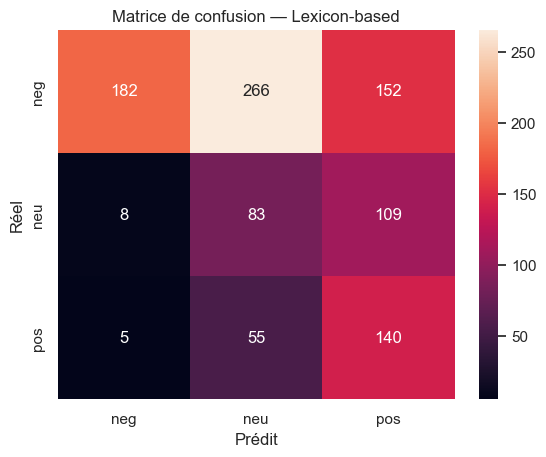

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy (lexicon-based):", accuracy_score(df["sentiment"], df["lex_pred"]))
print("\nClassification report:")
print(classification_report(df["sentiment"], df["lex_pred"], digits=3))

cm = confusion_matrix(df["sentiment"], df["lex_pred"], labels=["negative","neutral","positive"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.title("Matrice de confusion — Lexicon-based")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


In [58]:

df = dataset_all.to_pandas()

df = df[["text", "label", "lang"]]
df.head()

,text,label,lang
0,"Not What I Thought\n\nSadly, I thought this ob...",0,en
1,But extras\n\nThey work ok. They don’t last fo...,2,en
2,Also they claim it is leather but it feels lik...,2,en
3,"Two Stars\n\nIt's OK, but I was expecting much...",1,en
4,Nice piano-but mic broken in less than an hour...,1,en


In [59]:
df["text"] = df["text"].str.lower()
df = df.dropna(subset=["text", "label"])


In [60]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

tf_nb = Pipeline([
    ("vectorizer", CountVectorizer(
        stop_words="english",  # OK même avec FR/EN mélangé
        max_features=10000
    )),
    ("classifier", MultinomialNB())
])

tf_nb.fit(X_train, y_train)

y_pred_tf = tf_nb.predict(X_test)

print("Accuracy TF + NB:", accuracy_score(y_test, y_pred_tf))
print(classification_report(y_test, y_pred_tf))


Accuracy TF + NB: 0.44
              precision    recall  f1-score   support

           0       0.54      0.65      0.59        40
           1       0.26      0.23      0.24        40
           2       0.38      0.38      0.38        40
           3       0.38      0.45      0.41        40
           4       0.65      0.50      0.56        40

    accuracy                           0.44       200
   macro avg       0.44      0.44      0.44       200
weighted avg       0.44      0.44      0.44       200



In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_nb = Pipeline([
    ("vectorizer", TfidfVectorizer(
        stop_words="english",
        max_features=15000,
        ngram_range=(1, 2)  # mots + bigrammes
    )),
    ("classifier", MultinomialNB())
])

tfidf_nb.fit(X_train, y_train)

y_pred_tfidf = tfidf_nb.predict(X_test)

print("Accuracy TF-IDF + NB:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))


Accuracy TF-IDF + NB: 0.485
              precision    recall  f1-score   support

           0       0.50      0.72      0.59        40
           1       0.30      0.25      0.27        40
           2       0.39      0.38      0.38        40
           3       0.50      0.45      0.47        40
           4       0.71      0.62      0.67        40

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200



In [63]:
results = pd.DataFrame({
    "Model": ["TF + Naive Bayes", "TF-IDF + Naive Bayes"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_tf),
        accuracy_score(y_test, y_pred_tfidf)
    ]
})

results


,Model,Accuracy
0,TF + Naive Bayes,0.440
1,TF-IDF + Naive Bayes,0.485
